# Chest X-Ray Images classification

## 1. Introduction
Basing on image and patient data we want to classify into one or multiple classes

## 2. Data
We're working on dataset from Kaggle https://www.kaggle.com/nih-chest-xrays/data.
This NIH Chest X-ray Dataset comprises 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning.

### Data limitations:
The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation
### Class descriptions
There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

Atelectasis
Consolidation
Infiltration
Pneumothorax
Edema
Emphysema
Fibrosis
Effusion
Pneumonia
Pleural_thickening
Cardiomegaly
Nodule Mass
Hernia

In [149]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [150]:
image_paths = pd.DataFrame(glob("data/images_*/images/*.png"), columns=["path"])
image_paths["Image Index"] = image_paths["path"].apply(lambda x: x.split("/")[-1]) #verified

In [151]:
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')

In [152]:
all_xray_df.isna().sum() # verified

Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
dtype: int64

In [153]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [154]:
all_xray_df = all_xray_df.merge(image_paths, on="Image Index")

In [155]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,data/images_001/images/00000003_000.png


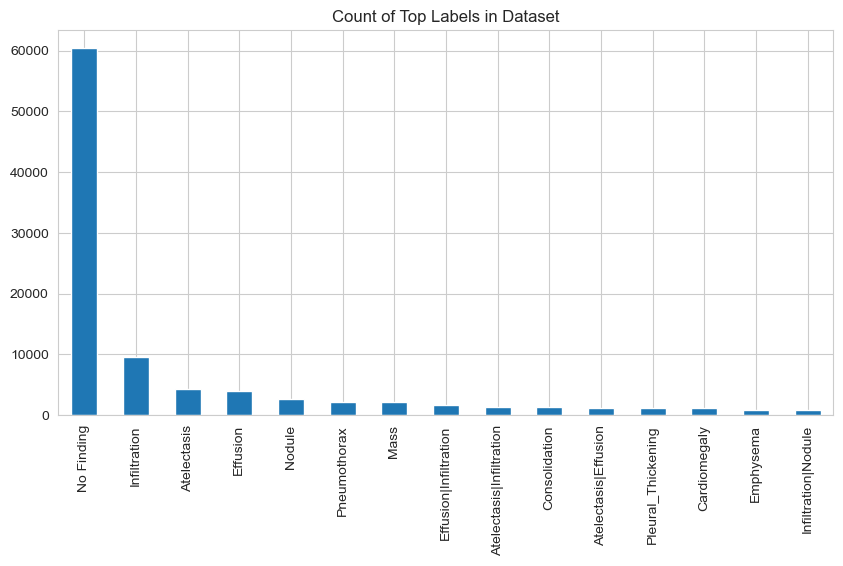

In [156]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

plt.figure(figsize=(10,5))
plt.title("Count of Top Labels in Dataset")
label_counts.plot.bar();

In [157]:
from bitarray import bitarray

# Define the class labels in a sorted set
all_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
unique_labels = all_labels.copy()

d = {label: ix for ix, label in enumerate(all_labels)}

# Column "Finding Labels" contains multiple label names separated by "|". "No Finding" means no disease.
# Define a function to convert "Finding Labels" to one-hot encoded in one hot encoded vector stored in "Disease Vector". "No Finding" is encoded as all zeros.
def convert_labels_to_vector(labels):
    # split labels by "|"
    labels = labels.split("|")
    # create a bitarray full of False with length of unique_diseases
    vector = bitarray('0'*14)
    # if "No Finding" in labels, return vector
    if "No Finding" in labels:
        return vector
    # for each label in labels, set the corresponding index in vector to 1
    for label in labels:
        vector[d[label]] = 1

    return vector

# Apply convert_labels_to_vector to "Finding Labels" column and store in "Disease Vector" column

In [158]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [159]:
all_xray_df.head() # verified

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum() > MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [161]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
xray_df = all_xray_df.copy()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

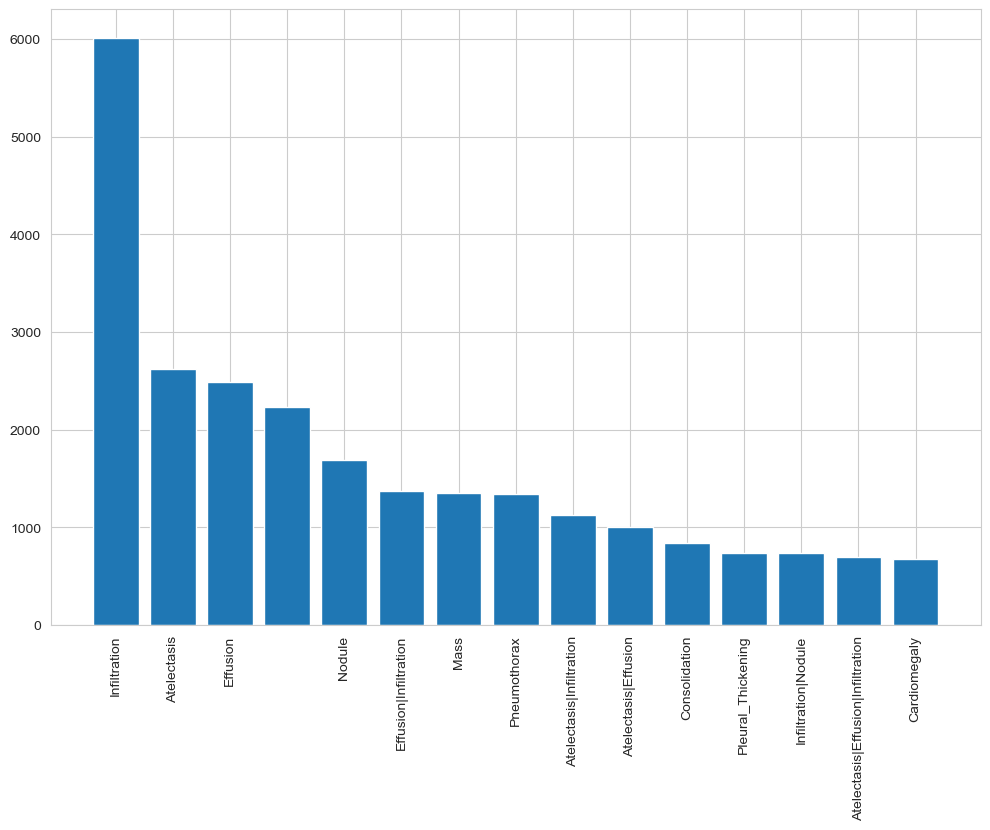

In [162]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [163]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
l_value_counts = sorted(zip(all_labels, label_counts), key=lambda x: x[1], reverse=True)

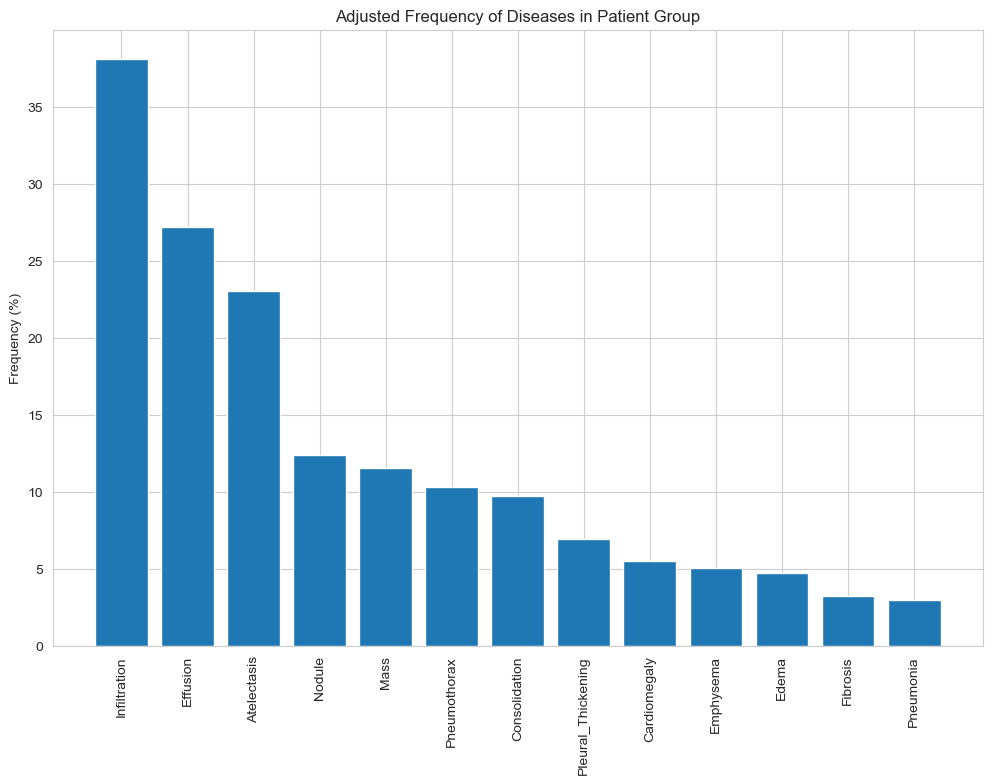

In [164]:
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, [v[1] for v in l_value_counts])
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels([v[0] for v in l_value_counts], rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [165]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0]) # verified
all_xray_df['disease_vec'].head()

81997    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12772    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
51899    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
55370    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
82077    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...
Name: disease_vec, dtype: object

In [166]:
all_xray_df['Finding Labels'].head()

81997                          Consolidation|Nodule
12772                            Atelectasis|Nodule
51899                                 Consolidation
55370                            Edema|Infiltration
82077    Consolidation|Effusion|Infiltration|Nodule
Name: Finding Labels, dtype: object

In [167]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df,
                                      test_size = 0.25,
                                      random_state = 2018,
                                      stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


In [173]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
92789,00023160_001.png,Mass,1,23160,43,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
41481,00010723_003.png,Nodule,3,10723,52,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9673,00002509_015.png,Nodule,15,2509,42,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
106019,00028526_014.png,Effusion|Infiltration,14,28526,34,M,AP,2544,3056,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
63121,00015605_029.png,Edema,29,15605,32,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [174]:
os.getcwd()

'/Users/blazej.przybyszewski/Desktop/src/chest-xray-classification'

In [168]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)

core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [188]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_dataframe(in_df, os.getcwd(),
                                              x_col = path_col,
                                              y_col = y_col,
                                              class_mode = 'raw',
                                              **dflow_args)
    # df_gen.filenames = in_df[path_col].values
    # df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    # df_gen.directory = os.getcwd()
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [189]:
train_gen = flow_from_dataframe(core_idg, train_df,
                                path_col = 'path',
                                y_col = 'disease_vec',
                                target_size = IMG_SIZE,
                                color_mode = 'grayscale',
                                batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df,
                                path_col = 'path',
                                y_col = 'disease_vec',
                                target_size = IMG_SIZE,
                                color_mode = 'grayscale',
                                batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg,
                                          valid_df,
                                          path_col = 'path',
                                          y_col = 'disease_vec',
                                          target_size = IMG_SIZE,
                                          color_mode = 'grayscale',
                                          batch_size = 1024))

## Ignore next message from keras, values are replaced anyways
Found 30000 validated image filenames.
Reinserting dataframe: 30000 images
## Ignore next message from keras, values are replaced anyways
Found 10000 validated image filenames.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 10000 validated image filenames.
Reinserting dataframe: 10000 images


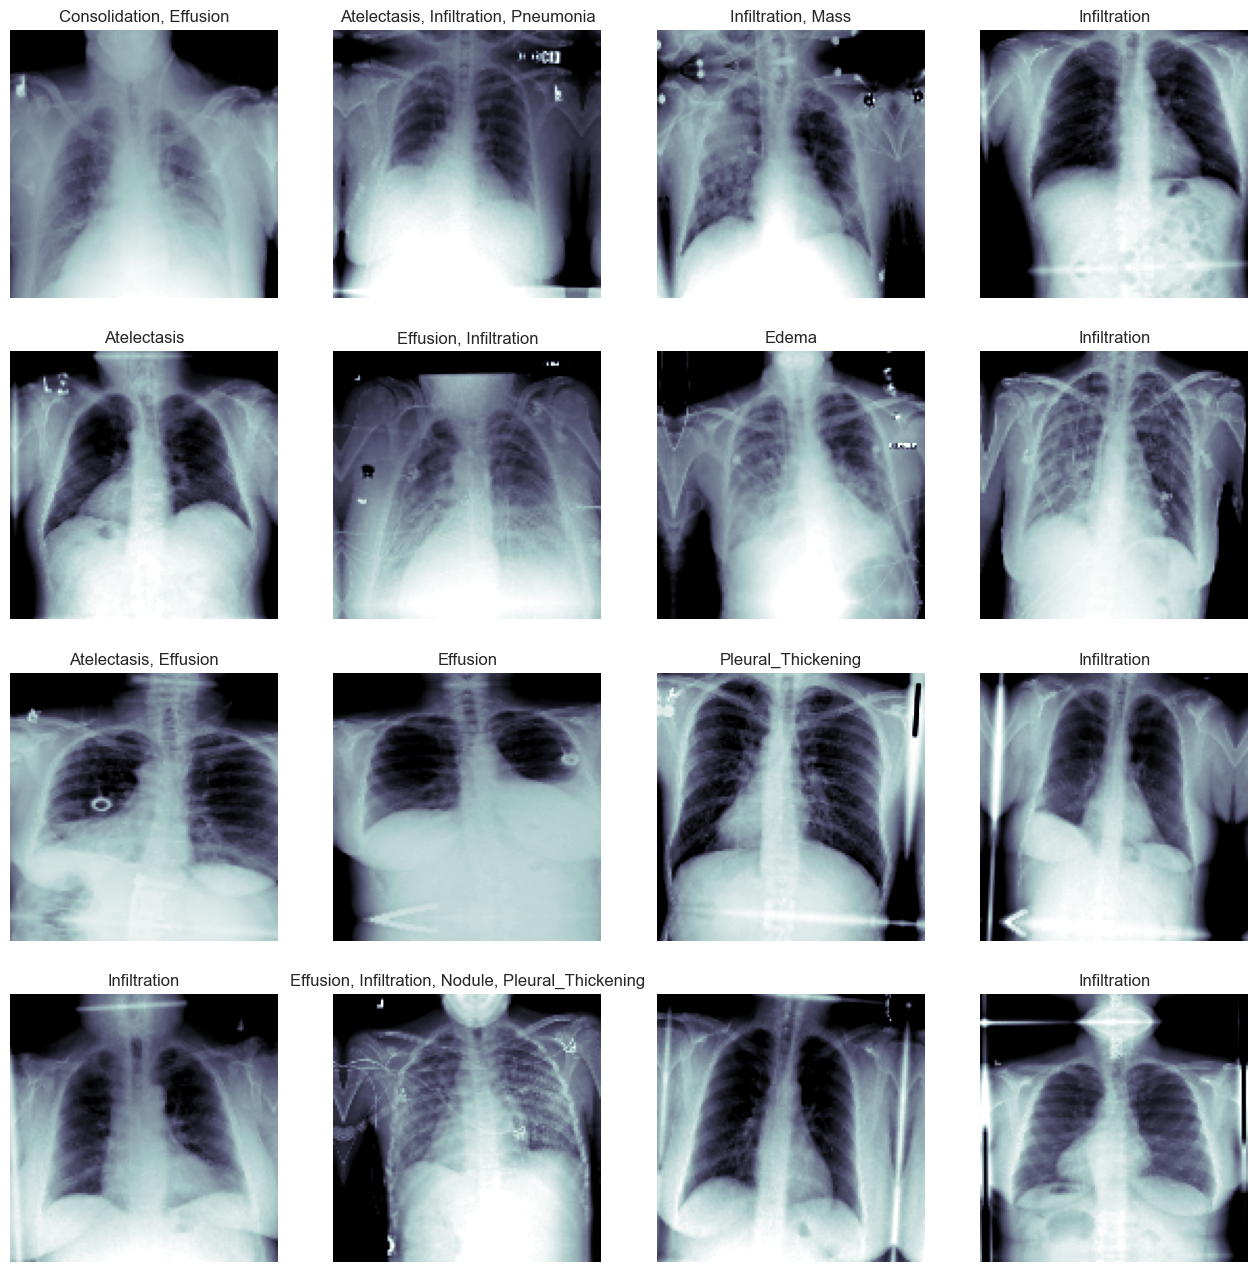

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                              if n_score>0.5]))
    c_ax.axis('off')

In [196]:
t_x.shape

(32, 128, 128, 1)

In [179]:
## Creating model

from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:],
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                            metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                6

In [180]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [checkpoint, early]

In [193]:
test_X

array([[[[-2.372806  ],
         [-2.3621075 ],
         [-2.356069  ],
         ...,
         [-2.3633132 ],
         [-2.37137   ],
         [-2.356069  ]],

        [[-2.3723814 ],
         [-2.3640785 ],
         [-2.356069  ],
         ...,
         [-2.3758185 ],
         [-2.3701549 ],
         [-2.361053  ]],

        [[-2.3620765 ],
         [-2.356069  ],
         [-2.356069  ],
         ...,
         [-2.3637452 ],
         [-2.372808  ],
         [-2.3751924 ]],

        ...,

        [[-2.356069  ],
         [-2.356069  ],
         [-2.356069  ],
         ...,
         [ 0.5152037 ],
         [ 0.43592927],
         [ 0.3642923 ]],

        [[-2.356069  ],
         [-2.356069  ],
         [-2.356069  ],
         ...,
         [ 0.47983578],
         [ 0.30792335],
         [ 0.18800753]],

        [[-2.356069  ],
         [-2.356069  ],
         [-2.356069  ],
         ...,
         [ 0.46348768],
         [ 0.39384535],
         [ 0.21020578]]],


       [[[-2.2637198 ],


In [201]:
# First round

multi_disease_model.fit(train_gen,
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y),
                                  epochs = 1,
                                  callbacks = callbacks_list)

ValueError: Can't convert non-rectangular Python sequence to Tensor.